<a href="https://colab.research.google.com/github/ilhamAdhim/Dicoding---Belajar-Pengembangan-Machine-Learning/blob/main/Submission_2_Time_Series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Muhammad Ilham Adhim** <br>
Submission 2 Time Series <br>
Dataset : https://www.kaggle.com/szrlee/stock-time-series-20050101-to-20171231?select=AABA_2006-01-01_to_2018-01-01.csv

In [1]:
# Import all required libraries
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

# Importing layers from keras. Use LSTM for input layer, and Dense for hidden and output layer
from keras.layers import Dense, LSTM, Dropout, Bidirectional 
from keras.models import Sequential

# Import SGD Optimizers
from tensorflow.keras.optimizers import SGD

# Import for splitting test and training data set
from sklearn.model_selection import train_test_split

In [2]:
#  Data AABA, provided are from 2006-01-01 to 2018-01-01
df = pd.read_csv('/content/drive/MyDrive/Dicoding - NLP - Sentiment Analysis /Submission 2/AABA_2006-01-01_to_2018-01-01.csv')

print("Total Data : {} \n".format(len(df)))
print("Date range from : {} to {}".format(df.head(1)['Date'].values, df.tail(1)['Date'].values))

Total Data : 3019 

Date range from : ['2006-01-03'] to ['2017-12-29']


In [3]:
# Display 10 latest data to check the latest date
df.tail(10)

,Date,Open,High,Low,Close,Volume,Name
3009,2017-12-15,69.35,70.54,68.66,70.29,19517623,AABA
3010,2017-12-18,70.54,70.74,69.95,70.14,6776982,AABA
3011,2017-12-19,69.70,70.36,69.38,70.21,14654994,AABA
3012,2017-12-20,70.60,71.05,70.17,70.90,12888149,AABA
3013,2017-12-21,71.00,72.17,70.88,71.59,9682733,AABA
3014,2017-12-22,71.42,71.87,71.22,71.58,10979165,AABA
3015,2017-12-26,70.94,71.39,69.63,69.86,8542802,AABA
3016,2017-12-27,69.77,70.49,69.69,70.06,6345124,AABA
3017,2017-12-28,70.12,70.32,69.51,69.82,7556877,AABA
3018,2017-12-29,69.79,70.13,69.43,69.85,6613070,AABA


In [4]:
# Drop unused columns for this submission
df_new = df.drop(['Open', 'High', 'Low', 'Volume', 'Name'], axis='columns')
# Display final dataframe, this will be used in further process
df_new

,Date,Close
0,2006-01-03,40.91
1,2006-01-04,40.97
2,2006-01-05,41.53
3,2006-01-06,43.21
4,2006-01-09,43.42
...,...,...
3014,2017-12-22,71.58
3015,2017-12-26,69.86
3016,2017-12-27,70.06
3017,2017-12-28,69.82


In [5]:
# Checking if there is any null values in the dataframe
if(df.isnull().sum()['Date'] == 0 and df.isnull().sum()['Close'] == 0):
  print("There is no null value, please continue")

There is no null value, please continue


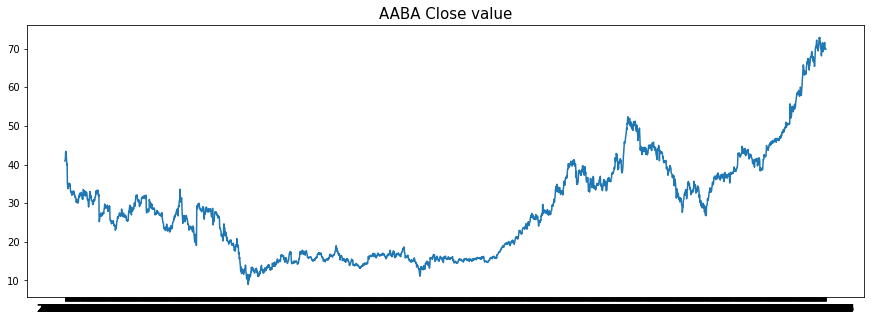

In [6]:
date_selected = df_new['Date'].values
close_val = df_new['Close'].values

# Look at the trend of AABA Close value by displaying it as a plot image
plt.figure(figsize=(15,5))
plt.plot(date_selected, close_val)
plt.title('AABA Close value',fontsize=15);

In [7]:
def windowed_dataset(series, shuffle_buffer, window_size = 40, batch_size = 100):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

In [8]:
# Splitting dataset to 80% Data Test and 20% Data Train
train_date, test_date, train_close, test_close = train_test_split(date_selected, close_val, test_size=0.2, shuffle=False)

# Call the windowed dataset function with splitted data
train_set = windowed_dataset(train_close, shuffle_buffer=1000)
test_set = windowed_dataset(test_close, shuffle_buffer=1000)

In [17]:
# Arsitektur Model
model = Sequential([
  LSTM(60, return_sequences=True),
  LSTM(60),
  Dropout(0.2),
  Dense(120, activation='relu'),
  Dense(60, activation="relu"),
  Dense(30, activation="relu"),
  Dense(1),
])

In [18]:
# Setting optimizer SGD Optimizer and learning rate
optimizer = SGD(learning_rate=1.0000e-03, momentum=0.9)

# Compile model with Huber and MAE (Mean Absolute Error) metrics
model.compile(
    loss=tf.keras.losses.Huber(),
    optimizer=optimizer,
    metrics=["mae"])              

In [19]:
# Create callback function to stop data training once the target MAE has been fulfilled
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if (logs.get('mae')<10) and (logs.get('val_mae')<10):
      print('\nMAE is lesser than 10%!')
      print('\nStop training model...')
      self.model.stop_training = True

# Inisiasi class myCallback ke dalam variable callbacks
custom_callback = myCallback()

In [20]:
# Training Model and save it to history variable.
history = model.fit(train_set, epochs=50, validation_data=test_set, callbacks=custom_callback)

Epoch 1/50
24/24 [==============================] - 7s 122ms/step - loss: 23.4148 - mae: 23.9148 - val_loss: 44.3774 - val_mae: 44.8774
Epoch 2/50
24/24 [==============================] - 2s 89ms/step - loss: 22.0037 - mae: 22.5037 - val_loss: 41.1799 - val_mae: 41.6799
Epoch 3/50
24/24 [==============================] - 2s 91ms/step - loss: 11.6346 - mae: 12.1278 - val_loss: 14.3838 - val_mae: 14.8787
Epoch 4/50
24/24 [==============================] - 2s 91ms/step - loss: 8.5173 - mae: 9.0017 - val_loss: 12.8769 - val_mae: 13.3673
Epoch 5/50
24/24 [==============================] - 2s 90ms/step - loss: 8.3702 - mae: 8.8542 - val_loss: 11.8217 - val_mae: 12.3052
Epoch 6/50
24/24 [==============================] - 2s 89ms/step - loss: 8.6641 - mae: 9.1510 - val_loss: 11.0373 - val_mae: 11.5266
Epoch 7/50
24/24 [==============================] - 2s 88ms/step - loss: 8.7849 - mae: 9.2726 - val_loss: 10.9057 - val_mae: 11.3950
Epoch 8/50
24/24 [==============================] - 2s 91ms/st

In [21]:
# Testing the forecasting accuracy

results = model.evaluate(test_set)
print("Result of  [val_loss,val_mae] for test data:")
print(results)

6/6 [==============================] - 0s 28ms/step - loss: 4.3304 - mae: 4.7713
Result of  [val_loss,val_mae] for test data:
[4.330423355102539, 4.7713470458984375]


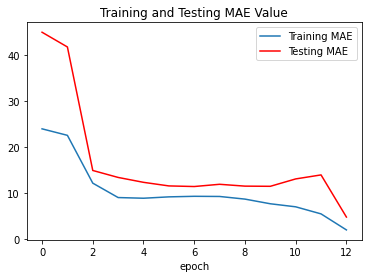

In [22]:
# Create plot for mae and val_mae
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'], 'r')
plt.title('Training and Testing MAE Value')
plt.xlabel('epoch')
plt.legend(['Training MAE', 'Testing MAE'], loc='upper right')
plt.show()

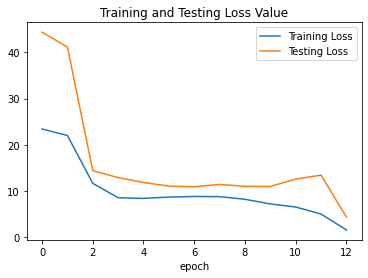

In [23]:
# Create plot for loss and val_loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training and Testing Loss Value')
plt.xlabel('epoch')
plt.legend(['Training Loss', 'Testing Loss'], loc='upper right')
plt.show()